In [1]:
%%capture
import os
import pandas as pd
import numpy as np
import mne
from mne.preprocessing import ICA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from scipy.signal import welch

In [2]:
%%capture
# Define a function to extract labels from filenames
def extract_label_from_filename(filename):
    # Assuming filenames are in the format: subject_task.bdf
    task = filename.split('_')[1].split('.')[0].split('-')[1]
    return task

In [3]:
%%capture
#Convert to DataFrame
def convert_bdf_to_dataframe(bdf_filename):
    
    # Loading Data
    raw_data = mne.io.read_raw_bdf(bdf_filename, preload=True)
    ## raw_data._data = raw_data._data ** 2
    
    # ICA
    n_components = 15
    ica = ICA(n_components=n_components, random_state=97, max_iter=800)
    ica.fit(raw_data)
    
    # Exclude components
    components_to_exclude = [7, 9]
    raw_cleaned = ica.apply(raw_data.copy(), exclude=components_to_exclude)
    
    # convert to dataframe
    eeg_data_raw = raw_cleaned.get_data()
    channel_names = raw_cleaned.ch_names
    time_index = raw_cleaned.times
        
    eeg_data = pd.DataFrame(data=eeg_data_raw.T, columns=channel_names, index=time_index)
    col_names = ["AF3", "AF4", "P7", "P8", "FC5", "FC6", "T7", "T8", "Fp1", "Fp2", "Fpz", "O1", "O2"]
    eeg_data = eeg_data[col_names]
    
    # Group by each second
    segment_size = 1024
    num_segments = len(eeg_data) // segment_size
    reduced_df = pd.DataFrame(columns=eeg_data.columns)
    for i in range(num_segments):
        start_idx = i * segment_size
        end_idx = (i + 1) * segment_size
        segment_data = eeg_data.iloc[start_idx:end_idx]    
        mean_values = segment_data.mean()  #mean value of EEG data is calculated
        reduced_df = reduced_df.append(mean_values, ignore_index=True)

    return reduced_df, raw_data

In [4]:
req_cols = ["AF3", "AF4", "P7", "P8", "FC5", "FC6", "T7", "T8", "Fp1", "Fp2", "Fpz", "O1", "O2"]
main_df_cols = []

for col in req_cols:
    if col == 'O1' or col == 'O2':
        main_df_cols.append(f'{col} gamma mean')
        main_df_cols.append(f'{col} gamma psd_mean')
    else:
        main_df_cols.append(f'{col} alpha mean')
        main_df_cols.append(f'{col} alpha psd_mean')
        main_df_cols.append(f'{col} beta mean')
        main_df_cols.append(f'{col} beta psd_mean')
main_df_cols.append('task')
        
main_df = pd.DataFrame(columns=main_df_cols)

In [ ]:
main_df

In [ ]:
def extract_mean_and_psd_mean(reduced_decomp_df, label):
    values = []
    req_channels = reduced_decomp_df.columns
    for channel in req_channels:
        mean_val = reduced_decomp_df[channel].mean()
        _, psd = welch(reduced_decomp_df[channel], fs=256)
        values.append(mean_val)
        values.append(psd.mean())
    values.append(label)
    main_df.loc[main_df.shape[0]] = values

In [ ]:
data_dir1 = 'C:/Dataset_meditation/rishikesh_dataset/med2'# Replace with the path to your .bdf data directory (/Dataset - 3/)
data_dir2 = 'C:/Dataset_meditation/rishikesh_dataset/think1'

In [ ]:
%%capture

# Initialize empty lists to store data and labels
data = []
labels = []
raw_eegdata = []

# Loop through all files in the directory
for filename in os.listdir(data_dir1):
    if filename.endswith('.bdf'):
        # Convert the .bdf file to a DataFrame
        eeg_data, eeg_raw = convert_bdf_to_dataframe(os.path.join(data_dir1, filename))
        
        # Extract labels from filenames
        label = extract_label_from_filename(filename)
#         # Append data and labels
        raw_eegdata.append(eeg_raw)
    
        channel_name_1 = ['O1', 'O2']
        channel_name_2 = ["AF3", "AF4", "P7", "P8", "FC5", "FC6", "T7", "T8", "Fp1", "Fp2", "Fpz"]  # Add more channel names as needed

#         # Create dictionaries to store the filtered data
        eeg_dataframe = pd.DataFrame()


        # Loop through each channel and filter data
        for channel_name in channel_name_2:
            eeg_channel = eeg_raw.copy().pick_channels([channel_name])
    
            # Filter for Alpha (8-13 Hz)
            alpha_filtered = eeg_channel.filter(l_freq=8, h_freq=13)
            alpha_decomp = alpha_filtered.get_data()[0]
            eeg_dataframe[f'{channel_name} alpha'] = alpha_decomp
    
            # Filter for Beta (13-30 Hz)
            beta_filtered = eeg_channel.filter(l_freq=13, h_freq=30)
            beta_decomp = beta_filtered.get_data()[0]
            eeg_dataframe[f'{channel_name} beta'] = beta_decomp
    
        for channel_name in channel_name_1:
            eeg_channel = eeg_raw.copy().pick_channels([channel_name])
    
            # Filter for Gamma (30-40 Hz)
            gamma_filtered = eeg_channel.filter(l_freq=30, h_freq=40)
            gamma_decomp = gamma_filtered.get_data()[0]
            eeg_dataframe[f'{channel_name} gamma'] = gamma_decomp

        # Grouping data for each second
        segment_size = 1024
        num_segments = len(eeg_dataframe) // segment_size
        reduced_decomp_df = pd.DataFrame(columns=eeg_dataframe.columns)
        for i in range(num_segments):
            start_idx = i * segment_size
            end_idx = (i + 1) * segment_size
            segment_data = eeg_dataframe.iloc[start_idx:end_idx]    
            mean_values = segment_data.mean()
            sampling_frequency = 1024  
            reduced_decomp_df = reduced_decomp_df.append(mean_values, ignore_index=True)
        
        extract_mean_and_psd_mean(reduced_decomp_df, label)

In [ ]:
main_df.to_csv('main_df6.csv')

In [ ]:
%%capture

# Initialize empty lists to store data and labels
data = []
labels = []
raw_eegdata = []

for filename in os.listdir(data_dir2):
    if filename.endswith('.bdf'):
        # Convert the .bdf file to a DataFrame
        eeg_data, eeg_raw = convert_bdf_to_dataframe(os.path.join(data_dir2, filename))
        
        # Extract labels from filenames
        label = extract_label_from_filename(filename)
#         # Append data and labels
        raw_eegdata.append(eeg_raw)
    
        channel_name_1 = ['O1', 'O2']
        channel_name_2 = ["AF3", "AF4", "P7", "P8", "FC5", "FC6", "T7", "T8", "Fp1", "Fp2", "Fpz"]  # Add more channel names as needed

#         # Create dictionaries to store the filtered data
        eeg_dataframe = pd.DataFrame()


        # Loop through each channel and filter data
        for channel_name in channel_name_2:
            eeg_channel = eeg_raw.copy().pick_channels([channel_name])
    
            # Filter for Alpha (8-13 Hz)
            alpha_filtered = eeg_channel.filter(l_freq=8, h_freq=13)
            alpha_decomp = alpha_filtered.get_data()[0]
            eeg_dataframe[f'{channel_name} alpha'] = alpha_decomp
    
            # Filter for Beta (13-30 Hz)
            beta_filtered = eeg_channel.filter(l_freq=13, h_freq=30)
            beta_decomp = beta_filtered.get_data()[0]
            eeg_dataframe[f'{channel_name} beta'] = beta_decomp
    
        for channel_name in channel_name_1:
            eeg_channel = eeg_raw.copy().pick_channels([channel_name])
    
            # Filter for Gamma (30-40 Hz)
            gamma_filtered = eeg_channel.filter(l_freq=30, h_freq=40)
            gamma_decomp = gamma_filtered.get_data()[0]
            eeg_dataframe[f'{channel_name} gamma'] = gamma_decomp

        # Grouping data for each second
        segment_size = 1024
        num_segments = len(eeg_dataframe) // segment_size
        reduced_decomp_df = pd.DataFrame(columns=eeg_dataframe.columns)
        for i in range(num_segments):
            start_idx = i * segment_size
            end_idx = (i + 1) * segment_size
            segment_data = eeg_dataframe.iloc[start_idx:end_idx]    
            mean_values = segment_data.mean()
            sampling_frequency = 1024  
            reduced_decomp_df = reduced_decomp_df.append(mean_values, ignore_index=True)
        
        extract_mean_and_psd_mean(reduced_decomp_df, label)

In [ ]:
main_df.to_csv('main_df7.csv')

In [ ]:
df1 = pd.read_csv('main_df6.csv')

# Load the second CSV file into another DataFrame
df2 = pd.read_csv('main_df7.csv')

# Append df2 to df1
merged_df = pd.concat([df1, df2], ignore_index=True)

# Save the merged DataFrame to a new CSV file
merged_df.to_csv('merged_dataset_med2_think1.csv', index=False)

In [ ]:
main_df = pd.read_csv('merged_dataset_med2_think1.csv')

In [ ]:
main_df.drop('Unnamed: 0', axis = 1, inplace = True)

In [ ]:
main_df

In [ ]:
X = main_df.drop('task', axis = 1)
y = main_df['task']

In [19]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score


min_max_scaler = MinMaxScaler()
X_min = min_max_scaler.fit_transform(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_labels = label_encoder.classes_

X_train, X_test, y_train, y_test = train_test_split(X_min, y_encoded, test_size=0.1, random_state=42)

In [20]:
from sklearn.linear_model import LogisticRegression
# Create a Random Forest classifier (you can try other classifiers as well)
clf = LogisticRegression(random_state=11)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.6666666666666666

In [21]:
from sklearn.ensemble import AdaBoostClassifier

min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)
model = AdaBoostClassifier()

model.fit(X_train,y_train)
preds = model.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(accuracy)

0.7333333333333333


In [28]:
pip install xgboost


Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/11/6f/419545a6a344cfd1358a80c36a06431881d607830483ef63d7c38905cd22/xgboost-2.0.1-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.7 MB ? eta -:--:--
   ---------------------------------------- 0.2/99.7 MB 5.3 MB/s eta 0:00:19
   ---------------------------------------- 0.4/99.7 MB 6.5 MB/s eta 0:00:16
   ---------------------------------------- 0.8/99.7 MB 7.0 MB/s eta 0:00:15
   ---------------------------------------- 1.1/99.7 MB 8.1 MB/s eta 0:00:13
    --------------------------------------- 1.6/99.7 MB 8.4 MB/s eta 0:00:12
    --------------------------------------- 2.2/99.7 MB 9.2 MB/s eta 0:00:11
   - -------------------------------------- 2.5/99.7 MB 9.0 MB/s eta 0:00:11
   - -------------------------------------- 2.9/99.7 MB 9.3 MB/s eta 0:00:11
   - --------------------------

In [29]:
from xgboost import XGBClassifier

# Standardize the features (optional but recommended)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model = XGBClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
accuracy_score(y_test, preds)

0.8666666666666667

In [23]:
import numpy as np
from sklearn.svm import SVC

# Create an SVM classifier
clf = SVC(kernel='linear', C=1.0)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the classifier's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.67


In [24]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Evaluate the classifier on the test data (optional)
accuracy = clf.score(X_test, y_test)
print(f'Accuracy: {accuracy:.2f}')

# Get feature importances
feature_importances = clf.feature_importances_

# Print the importance of each feature
for feature, importance in zip(X.columns, feature_importances):
    print(f'{feature}: {importance:.4f}')

Accuracy: 0.77


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [25]:
import tensorflow as tf
from tensorflow import keras

# Define a neural network model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(len(class_labels), activation='softmax')  # Output layer with softmax activation
])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# Compile the model with categorical cross-entropy loss
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical cross-entropy
              metrics=['accuracy'])

# Convert target labels to one-hot encoding
y_train_one_hot = keras.utils.to_categorical(y_train, len(class_labels))
y_test_one_hot = keras.utils.to_categorical(y_test, len(class_labels))

# Train the model
model.fit(X_train, y_train_one_hot, epochs=100, batch_size=64, validation_split=0.2, callbacks=[callback])

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test_one_hot)
print(f'Test accuracy: {test_acc:.4f}')

# Make predictions
predictions = model.predict(X_test)

# Convert predicted labels back to string labels
predicted_labels = [class_labels[np.argmax(pred)] for pred in predictions]
predicted_labels_encoded = label_encoder.transform(predicted_labels)

Epoch 1/100
4/4 [==============================] - 0s 32ms/step - loss: 0.6566 - accuracy: 0.6540 - val_loss: 0.6041 - val_accuracy: 0.7170
Epoch 2/100
4/4 [==============================] - 0s 4ms/step - loss: 0.6428 - accuracy: 0.6540 - val_loss: 0.6029 - val_accuracy: 0.7170
Epoch 3/100
4/4 [==============================] - 0s 6ms/step - loss: 0.6424 - accuracy: 0.6540 - val_loss: 0.6015 - val_accuracy: 0.7170
Epoch 4/100
4/4 [==============================] - 0s 5ms/step - loss: 0.6403 - accuracy: 0.6540 - val_loss: 0.5982 - val_accuracy: 0.7170
Epoch 5/100
4/4 [==============================] - 0s 5ms/step - loss: 0.6388 - accuracy: 0.6540 - val_loss: 0.5960 - val_accuracy: 0.7170
Epoch 6/100
4/4 [==============================] - 0s 5ms/step - loss: 0.6394 - accuracy: 0.6540 - val_loss: 0.5945 - val_accuracy: 0.7170
Epoch 7/100
4/4 [==============================] - 0s 348us/step - loss: 0.6364 - accuracy: 0.6540 - val_loss: 0.5995 - val_accuracy: 0.7170
Epoch 8/100
4/4 [=======

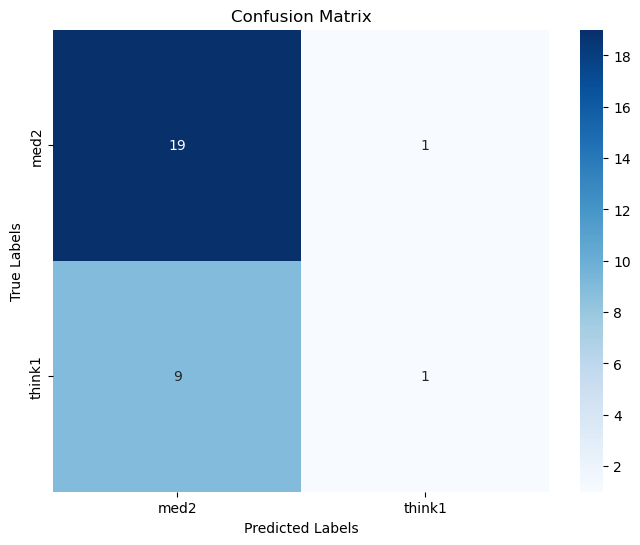

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test contains true labels and predicted_labels contains predicted labels
# These should be NumPy arrays or Python lists.

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels_encoded)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

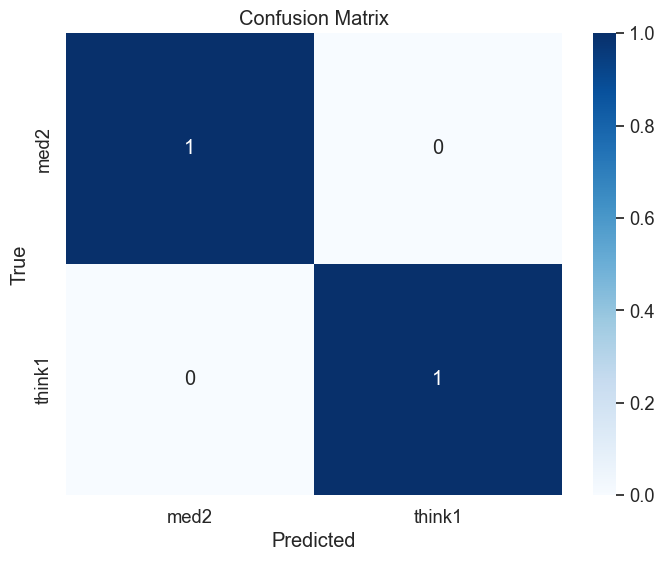

              precision    recall  f1-score   support

        med2       1.00      1.00      1.00         1
      think1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Replace these with your actual predicted and true labels
predicted_labels = y.unique()
true_labels = y.unique()

# Get the unique class names from the labels
class_names = np.unique(true_labels)

# Compute the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels, labels=class_names)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# You can also print a classification report with precision, recall, and F1-score
print(classification_report(true_labels, predicted_labels, target_names=class_names))